# Assignment 2

By Gal Noy

### Test Plan
In this assignment, I will test my implementation of the Flajolet-Martin ($\alpha$, $\beta$, and final estimators) 
and Count-Min Sketch algorithms. These algorithms will be examined with different sketch sizes.

The stream used for testing contains 100,000 elements, with 10,000 of them being unique.

For each estimator, the following steps will be performed:
1. Run each sketch size 25 times to ensure statistical consistency.
2. For every sketch size, compute and visualize:
   - Accuracy
   - Bias
   - Normalized variance
3. Determine the relative error (with $\epsilon$) that ensures a 95% success rate ($\delta = 0.05$).
4. Validate and illustrate the unbiasedness of the estimators.

## Initialization


In [284]:
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000
NUM_UNIQUE = 10000
NUM_RUNS = 25

# Set the seed for reproducibility
np.random.seed(SEED)
stream = np.random.randint(0, NUM_UNIQUE, NUM_ELEMENTS)

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {len(np.unique(stream))}")
print(f"First 10 elements of the stream: {stream[:10]}")

Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: [7270  860 5390 5191 5734 6265  466 4426 5578 8322]


### Hashing

Below is a hash function implementation used to process the stream and a visualization of its uniformity.

The hash function is defined as:

$$h(x) = ((a \cdot x^2 + b) \mod p) \mod m$$

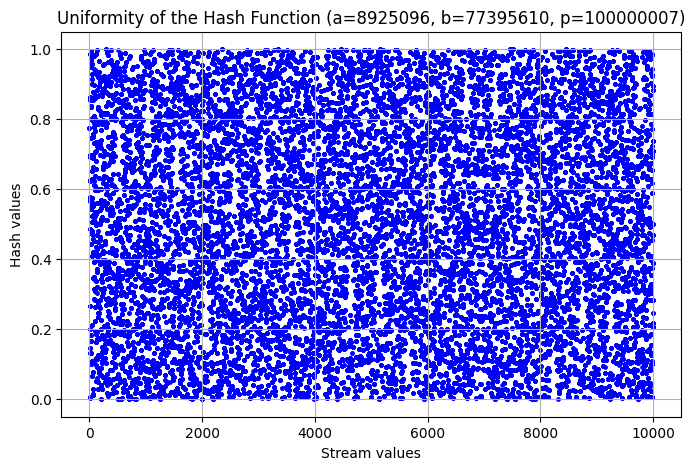

In [285]:
import matplotlib.pyplot as plt

# Prime number for the hash function, P > NUM_UNIQUE^2
P = NUM_UNIQUE**2 + 7

def hash_stream(stream: np.ndarray, a: int, b: int, m: int = P, normalize: bool = True, p: int = P) -> np.ndarray:
    """
    Hash the stream using the hash function (a * stream + b)^3 % p % m.
    :param stream: The stream to hash
    :param a: The first coefficient of the hash function
    :param b: The second coefficient of the hash function
    :param p: The prime number for the hash function
    :param m: The range of the hash function
    :param normalize: Whether to normalize the hash values to [0, 1) or not
    :return: The hashed stream
    """
    return (((a * stream**2 + b) % p) % m) / (m if normalize else 1)

# Plot the uniformity of the hash function
a, b = np.random.default_rng(SEED).integers(1, P, size=2)
plt.figure(figsize=(8, 5))
plt.scatter(stream, hash_stream(stream, a, b), alpha=0.7, color='blue', s=5)
plt.title(f"Uniformity of the Hash Function (a={a}, b={b}, p={P})")
plt.xlabel("Stream values")
plt.ylabel("Hash values")
plt.grid(True)
plt.show()

## Flajolet Martin

### Flajolet Martin - $\alpha$-Version

In [286]:
def flajolet_martin(stream: np.ndarray, seed: int = SEED) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param seed: seed for the random number generator
    :return: estimated number of distinct elements
    """
    a, b = np.random.default_rng(seed).integers(1, P, size=2)
    hashed_stream = hash_stream(stream, a, b)
    return 1 / np.min(hashed_stream)

In the $\alpha$-version, the sketch size is always set to 1, as there is only one estimator. If we choose a relatively large value for $\epsilon$, such as $\frac{1}{2}$, then:

$$
O\left(\frac{1}{\epsilon^2}\right) < \delta
$$

This results in $\delta > 1$, which is not acceptable since $\delta$ must be less than or equal to 1.

This means the estimator is not sufficiently accurate, as the relative error, guaranteed with 95\% success probability ($\delta = 0.05$), is $\epsilon > \sqrt{20} > 4$. In other words, the estimated count could be more than four times the actual number of unique elements.

Proof of **unbiasedness** is only possible mathematically, by proving $E\left[\frac{1}{X}\right] = n$.

In [287]:
estimates = [flajolet_martin(stream, i) for i in range(NUM_RUNS)]
mean = np.mean(estimates)
accuracy = max(0, 1 - np.abs(mean - NUM_UNIQUE) / NUM_UNIQUE)
bias = np.abs(mean - NUM_UNIQUE)
normalized_variance = np.var(estimates) / NUM_UNIQUE

print("Flajole-Martin Algorithm")
print(f"Mean estimate: {mean:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Bias: {bias:.2f}")
print(f"Normalized variance: {normalized_variance:.2f}")

Flajole-Martin Algorithm
Mean estimate: 81961.89
Accuracy: 0.00
Bias: 71961.89
Normalized variance: 4447725.19


### Flajolet Martin - $\beta$-Version

The $\beta$-version of the Flajolet-Martin algorithm improves accuracy by using $s$ estimators, each based on a different hash function.

The final cardinality estimate $N^{\beta}$ is computed as:

$$
N^{\beta} = \frac{1}{\text{mean of estimators}} - 1
$$

In [288]:
def flajolet_martin_beta(stream: np.ndarray, s: int, seed: int = SEED) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :param seed: seed for the random number generator
    :return: estimated number of distinct elements
    """
    hash_funcs = np.random.default_rng(seed).integers(0, P, size=(s, 2))
    estimates = np.array([hash_stream(stream, a, b) for a, b in hash_funcs])    
    Z = np.min(estimates, axis=1)
    return 1 / np.mean(Z) - 1

We learned in class that $O\left(\frac{1}{\epsilon^2 \delta}\right)$ space is needed to guarantee the accuracy of $P(|N^{\beta} - N| > \epsilon N) < \delta$.

For each sketch size, we will calculate the promised relative error for 95% success probability ($\delta = 0.05$) using the formula:

$$
\text{Relative Error} = \epsilon = \sqrt{\frac{\delta}{s}}
$$

Sketch size: 1, Relative error: 4.47
Sketch size: 2, Relative error: 3.16
Sketch size: 4, Relative error: 2.24
Sketch size: 8, Relative error: 1.58
Sketch size: 16, Relative error: 1.12
Sketch size: 32, Relative error: 0.79
Sketch size: 64, Relative error: 0.56
Sketch size: 128, Relative error: 0.40
Sketch size: 256, Relative error: 0.28


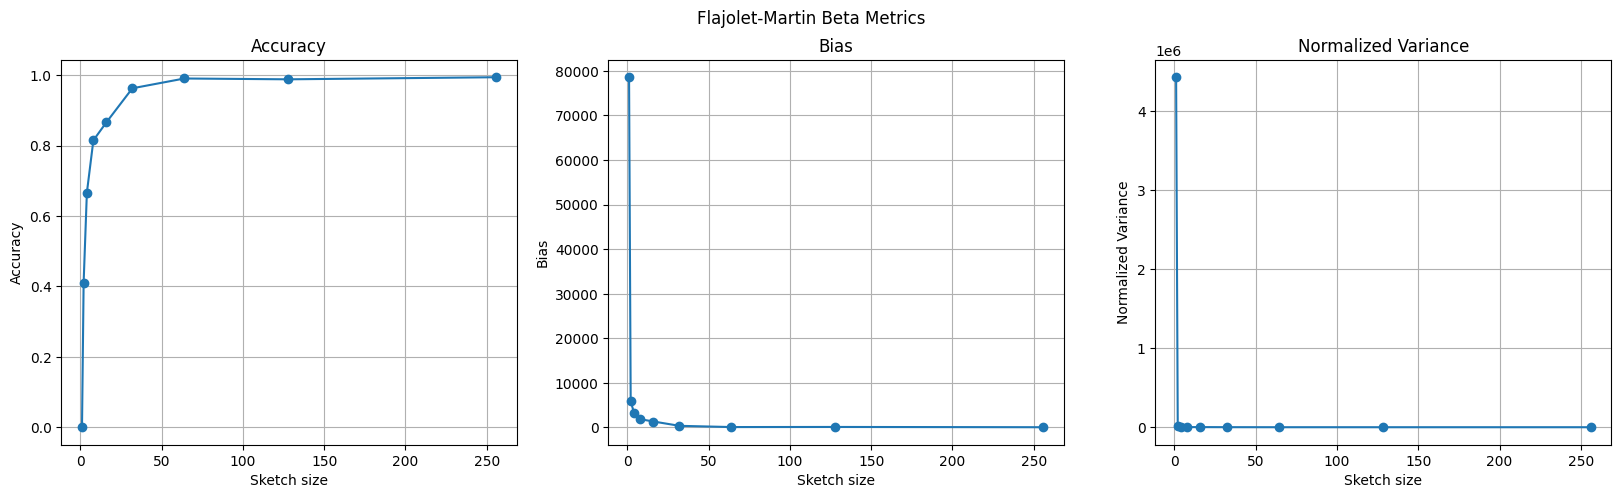

In [289]:
import matplotlib.pyplot as plt

S = [1, 2, 4, 8, 16, 32, 64, 128, 256]

# Calculate the guaranteed relative error with 95% confidence
delta = 0.05
for s in S:
    epsilon = np.sqrt(1 / (delta * s))
    print(f"Sketch size: {s}, Relative error: {epsilon:.2f}")

results = {s: [flajolet_martin_beta(stream, s, i) for i in range(NUM_RUNS)] for s in S}

def calculate_fm_metrics(results: dict) -> dict:
    """
    Calculate the metrics for the Flajolet-Martin Beta algorithm.
    :param results: Dictionary with the results
    :return: Dictionary with the metrics
    """
    metrics = {}
    for sketch_size, ests in results.items():
        mean = np.mean(ests)
        accuracy = max(0, 1 - np.abs(mean - NUM_UNIQUE) / NUM_UNIQUE)
        bias = np.abs(mean - NUM_UNIQUE)
        normalized_variance = np.var(ests) / NUM_UNIQUE
        metrics[sketch_size] = {
            "accuracy": accuracy,
            "bias": bias,
            "normalized_variance": normalized_variance
        }
    return metrics

def plot_metrics(metrics: dict, title: str, logx: bool = False):
    """
    Plot the metrics for the Flajolet-Martin Beta algorithm.
    :param metrics: Dictionary with the metrics
    :param title: Title of the plot
    """
    sketch_sizes = sorted(list(metrics.keys()))
    
    plt.figure(figsize=(20, 5))
    plt.suptitle(title)

    plt.subplot(1, 3, 1)
    plt.plot(sketch_sizes, [metrics[s]["accuracy"] for s in sketch_sizes], marker='o')
    plt.title("Accuracy")
    plt.xlabel("Sketch size")
    if logx:
        plt.xscale("log")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(sketch_sizes, [metrics[s]["bias"] for s in sketch_sizes], marker='o')
    plt.title("Bias")
    plt.xlabel("Sketch size")
    if logx:
        plt.xscale("log")
    plt.ylabel("Bias")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(sketch_sizes, [metrics[s]["normalized_variance"] for s in sketch_sizes], marker='o')
    plt.title("Normalized Variance")
    plt.xlabel("Sketch size")
    if logx:
        plt.xscale("log")
    plt.ylabel("Normalized Variance")
    plt.grid(True)

    plt.show()

metrics = calculate_fm_metrics(results)
plot_metrics(metrics, "Flajolet-Martin Beta Metrics")

As the sketch size $s$ increases, we observe the following trends in the accuracy, bias, and normalized variance of the estimator:

1. **Accuracy**: The accuracy of the estimator increases as the sketch size grows, approaching 1.0. This indicates that the estimator becomes more accurate with a larger sketch size, providing estimates closer to the true count. This also shows the *unbiasedness* of the estimator, as the estimate is closer to the true count as long as the sketch size grows.

2. **Bias**: The bias of the estimator decreases quickly as the sketch size increases. For small $s$, the bias is significant, but as $s$ grows, the bias approaches zero. This shows that the estimator becomes less biased and provides results that are closer to the true value as more estimators are used.

3. **Normalized Variance**: The normalized variance follows a similar pattern to the bias, dropping sharply as the sketch size increases. For small $s$, the variance is high, but it becomes almost negligible as $s$ increases. This suggests that with a larger number of estimators, the variance decreases, leading to more consistent and reliable estimates.

This demonstrates the **unbiasedness** of the estimator: as $s$ grows, the estimator's expected value approaches the true count, leading to smaller deviations and a more reliable estimate of the cardinality.

### Flajolet Martin - Final Version

The final version of the Flajolet-Martin algorithm improves accuracy by using $t$ $\beta$-version estimators, each based on a different hash function. For each $\beta$ estimator, the cardinality estimate $N^{\beta}_i$ is computed as:

$$
N^{\beta}_i = \frac{1}{\text{mean of estimators}} - 1
$$

The final estimate $\hat{N}$ is then computed as the **median** of all these individual estimates:

$$
\hat{N} = \text{median}(N^{\beta}_1, N^{\beta}_2, \dots, N^{\beta}_t)
$$


In [290]:
def flajolet_martin_final(stream: np.ndarray, t: int, s: int, seed: int = SEED) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :param seed: seed for the random number generator
    :return: median of the distinct element estimates
    """
    hash_funcs = np.random.default_rng(seed).integers(0, P, size=(t, s, 2))
    
    Zs = [np.min([hash_stream(stream, a, b) for a, b in hash_funcs[i]], axis=1) for i in range(t)]
    estimates = [1 / np.mean(Z) - 1 for Z in Zs]
        
    return np.median(estimates)

We learned in class that $O\left(\frac{1}{\epsilon^2} \log \frac{1}{\delta}\right)$
 space is needed to guarantee the accuracy of $P(|\hat{N} - N| > \epsilon N) < \delta$.

For each sketch size, we will calculate the promised relative error for 95\% success probability ($\delta = 0.05$) using the formula:

$$
\text{Relative Error} = \epsilon = \sqrt{\frac{\log \frac{1}{\delta}}{t \cdot s}}
$$

Sketch size: t = 1, s = 1, Relative error: 1.73
Sketch size: t = 1, s = 2, Relative error: 1.22
Sketch size: t = 1, s = 4, Relative error: 0.87
Sketch size: t = 2, s = 4, Relative error: 0.61
Sketch size: t = 2, s = 8, Relative error: 0.43
Sketch size: t = 2, s = 16, Relative error: 0.31
Sketch size: t = 4, s = 16, Relative error: 0.22
Sketch size: t = 4, s = 32, Relative error: 0.15
Sketch size: t = 4, s = 64, Relative error: 0.11


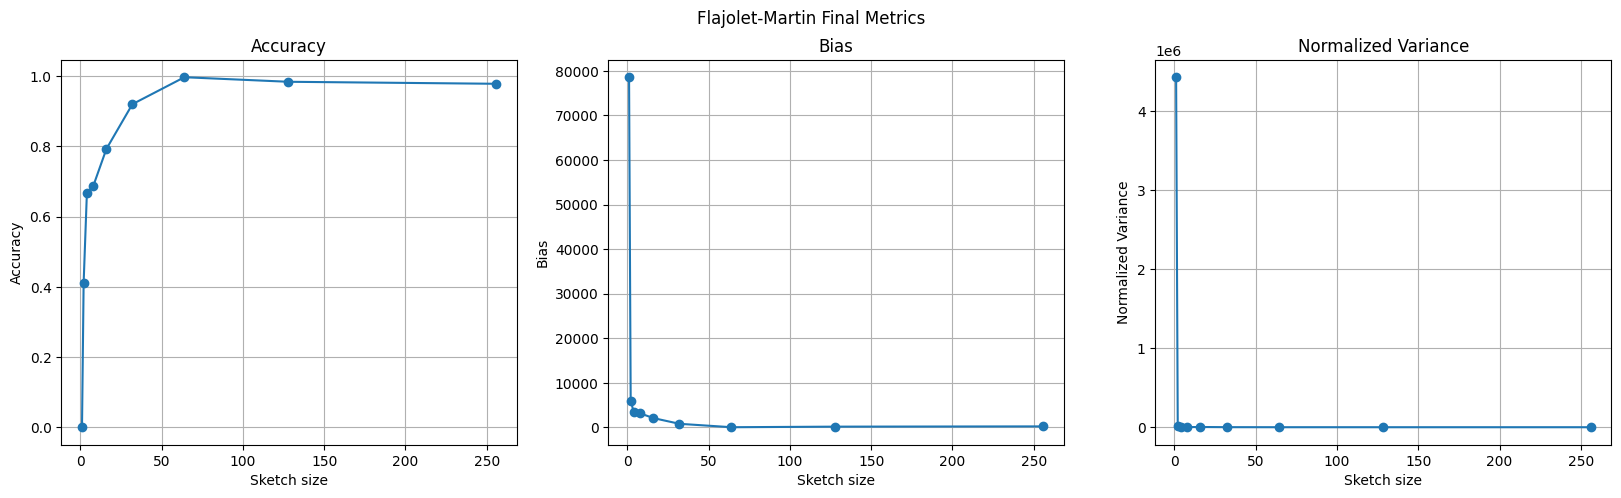

In [296]:
TS = [(1, 1), (1, 2), (1, 4),
      (2, 4), (2, 8), (2, 16),
      (4, 16), (4, 32), (4, 64)]

for t, s in TS:
    epsilon = np.sqrt(np.log(1 / delta) / (t * s))
    print(f"Sketch size: t = {t}, s = {s}, Relative error: {epsilon:.2f}")

results = {t * s: [flajolet_martin_final(stream, t, s, i) for i in range(NUM_RUNS)] for t, s in TS}

metrics = calculate_fm_metrics(results)

plot_metrics(metrics, "Flajolet-Martin Final Metrics")

Similar to the $\beta$ version, the final version of the estimator shows the following trends in accuracy, bias, and normalized variance as the sketch size increases:

1. **Accuracy**: The accuracy sharply increases as the sketch size grows, achieving near 1.0 very quickly. The accuracy stabilizes with larger sketch sizes, but it reaches a higher value more rapidly compared to the beta version. This indicates that the estimator's accuracy is significantly improved in the final version, providing more precise estimates with fewer estimators.

2. **Bias**: The bias decreases sharply as the sketch size increases. However, in this version, the bias reduction is more drastic at smaller sketch sizes. After a certain point, the bias remains close to zero, which suggests that the estimator reaches a high level of reliability and near-zero bias with a relatively small increase in sketch size.

3. **Normalized Variance**: The normalized variance also follows a steep drop as the sketch size increases. In the final version, the normalized variance reduces almost immediately after the first few increases in sketch size, and it quickly becomes very small, indicating that the variance is significantly reduced in the final version, leading to more stable and consistent results.


## Count-Min Sketch

The Count-Min Sketch algorithm is a probabilistic data structure used to estimate the frequency of elements in a stream with the trade-off of allowing some error. It uses a 2D array (or matrix) of counters, where each row corresponds to a hash function and each column corresponds to a hash value for an element. The algorithm uses these hash functions to map elements to specific positions in the counters, and it returns an approximate count of each element in the stream.

This implementation works as follows:

1. **Initialization**: The sketch is initialized as a 2D array of zeros with dimensions `d x w`, where `d` is the depth (number of hash functions) and `w` is the width (size of the counter array for each hash function).

2. **Hash Functions**: The algorithm generates `d` random hash functions, each producing a pair of indices. These indices are used to map each unique element in the stream to positions in the sketch.

3. **Update the Sketch**: For each element in the stream, the sketch is updated at the corresponding hash indices with the element's frequency.

4. **Estimate Frequencies**: The estimated frequency of each unique element is calculated by taking the minimum value across all rows for the corresponding column indices. This helps reduce the effect of hash collisions.

### Formula

The Count-Min Sketch estimate for the frequency of an element $x$ is given by:

$$
\hat{f}(x) = \min_{1 \leq i \leq d} \text{sketch}[i, \text{hash}_i(x)]
$$

In [297]:
def count_min_sketch(stream: np.ndarray, d: int, w: int, seed: int = SEED) -> np.ndarray:
    """
    Count-Min Sketch algorithm for counting the frequency of elements in a stream.
    :param stream: array of elements
    :param d: depth of the sketch (number of hash functions)
    :param w: width of the sketch
    :param seed: seed for the random number generator
    :return: estimated frequency of each unique element in the stream
    """
    # Initialize the sketch
    sketch = np.zeros((d, w))
    
    # Hash each unique stream elements to d indices (one for each hash function)
    hash_funcs = np.random.default_rng(seed).integers(0, w, size=(d, 2))
    unique_elements, counts = np.unique(stream, return_counts=True)
    unique_element_to_indices = np.array([[int(val) for val in hash_stream(unique_elements, a, b, w, normalize=False)] for a, b in hash_funcs]).T
    assert unique_element_to_indices.shape == (len(unique_elements), d), f"Unique element to indices shape: {unique_element_to_indices.shape}"
    
    # According to each unique element frequency (count), update the sketch at the hashed indices
    np.add.at(sketch, (np.arange(d)[:, None], unique_element_to_indices.T), counts)

    # Calculate estimated frequencies for each unique element in the stream
    freqs = np.array([np.min([sketch[j, unique_element_to_indices[i, j]] for j in range(d)]) for i in range(len(unique_elements))])
    
    return freqs

We learned in class that a space of $O\left( \frac{\log F_1 \cdot \log \frac{1}{\delta}}{\epsilon} \right)$ is needed to guarantee the accuracy of the following inequality:

$$
P\left( f_{x} \leq \hat{f}_{x} \leq f_{x} + \epsilon F_1 \right) \geq 1 - \delta
$$

For each sketch size $s = d \cdot w$, we will calculate the promised relative error for 95\% success probability ($\delta = 0.05$) using the formula:

$$
\text{Relative Error} = \epsilon = \frac{\log F_1 \cdot \log \frac{1}{\delta}}{d \cdot w}
$$

*Reminder: $F_1$ is the first norm, i.e., $F_1 = \sum_x |f_x|$

Depth: 1, Width: 100, Relative error: 0.59
Depth: 1, Width: 500, Relative error: 0.26
Depth: 1, Width: 1000, Relative error: 0.19
Depth: 1, Width: 5000, Relative error: 0.08
Depth: 1, Width: 10000, Relative error: 0.06
Depth: 1, Width: 50000, Relative error: 0.03
Depth: 2, Width: 100, Relative error: 0.42
Depth: 2, Width: 500, Relative error: 0.19
Depth: 2, Width: 1000, Relative error: 0.13
Depth: 2, Width: 5000, Relative error: 0.06
Depth: 2, Width: 10000, Relative error: 0.04
Depth: 2, Width: 50000, Relative error: 0.02
Depth: 3, Width: 100, Relative error: 0.34
Depth: 3, Width: 500, Relative error: 0.15
Depth: 3, Width: 1000, Relative error: 0.11
Depth: 3, Width: 5000, Relative error: 0.05
Depth: 3, Width: 10000, Relative error: 0.03
Depth: 3, Width: 50000, Relative error: 0.02


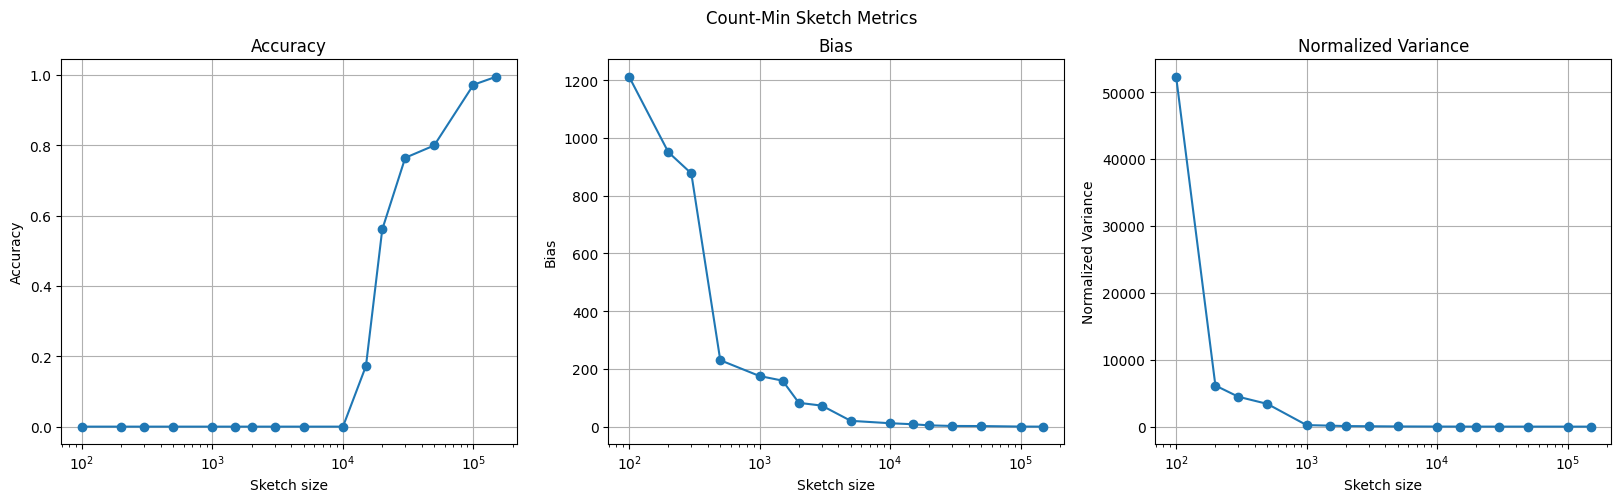

In [306]:
DW = [(1, 100), (1, 500), (1, 1000), (1, 5000), (1, 10000), (1, 50000), 
      (2, 100), (2, 500), (2, 1000), (2, 5000), (2, 10000), (2, 50000), 
      (3, 100), (3, 500), (3, 1000), (3, 5000), (3, 10000), (3, 50000)]

F1 = NUM_ELEMENTS
for d, w in DW:
    epsilon = np.sqrt(np.log(F1) * np.log(1 / delta) / (d * w))
    print(f"Depth: {d}, Width: {w}, Relative error: {epsilon:.2f}")
    
results = {d * w: [count_min_sketch(stream, d, w, i) for i in range(NUM_RUNS)] for d, w in DW}

unique_elements, counts = np.unique(stream, return_counts=True)

metrics = {}
for sketch_size, freqs_list in results.items():    
    # Accuracy (with Mean Absolute Error)
    errors = [np.sum(np.abs(freqs - counts)) for freqs in freqs_list]
    mean_absolute_error = np.mean(errors)
    accuracy = max(0, 1 - mean_absolute_error / len(stream))
    
    # Average bias, average normalized-variance
    biases = []
    variances = []
    for i, _ in enumerate(unique_elements):
        estimates = np.array([freqs[i] for freqs in freqs_list])
        true_count = counts[i]
        bias = np.mean(estimates) - true_count
        variance = np.var(estimates) / true_count
        biases.append(bias)
        variances.append(variance)
    
    avg_bias = np.mean(np.abs(biases))
    avg_normalized_variance = np.mean(variances)
    
    metrics[sketch_size] = {
        "accuracy": accuracy,
        "bias": avg_bias,
        "normalized_variance": avg_normalized_variance
    }
    
plot_metrics(metrics, "Count-Min Sketch Metrics", logx=True)

As the sketch size $s$ (controlled by the depth $d$ and width $w$) increases, the following trends are observed for the accuracy, bias, and normalized variance:

1. **Accuracy**: The accuracy increases sharply with larger sketch sizes. For smaller sketch sizes, the accuracy is quite low, but as the size grows, the estimator becomes highly accurate, approaching 1.0. This suggests that with increasing sketch size, the estimator’s output gets closer to the true count of the elements in the stream.

2. **Bias**: The bias of the estimator decreases rapidly with larger sketch sizes. For small sketch sizes, the bias is quite significant, but as the sketch size increases, the bias diminishes and approaches zero. This indicates that the estimator is less biased with larger sketch sizes and provides estimates that are closer to the true values.

3. **Normalized Variance**: The normalized variance follows a similar pattern as bias. For smaller sketch sizes, the variance is very high, but as $s$ increases, the variance drops sharply. This shows that with larger sketch sizes, the estimator becomes more stable, with smaller fluctuations in estimates and more reliable results.

In summary, these results demonstrate the **unbiasedness** of the Count-Min sketch estimator: as the sketch size increases, the accuracy improves, bias decreases, and variance reduces, leading to more reliable and consistent estimates of the cardinality.
